In [1]:
import Pkg
Pkg.activate("../../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
using Revise
using LinearAlgebra
using Statistics
using Plots


includet("../src/TCVAR.jl")

using .TCVAR

In [3]:
trend_mapping = [1 0
                 1 1]

true_var_coeff = [.3 .1;  .4 .6]
true_trend_covariance =  diagm([2/10, 1/10] .^2) 

p = -0.7 * .03 * 0.01

true_cycle_covariance = [(2.)^2 p
                         p (1.)^2]

     
true_initial_trend_mean = [2., 1.]
true_initial_trend_covariance = Matrix(I, 2,2)
true_initial_cycle_mean = [.0, .0]
true_initial_cycle_covariance = [(2.)^2 0
                                 0 (1.)^2]
                                   
    
true_model = tc_var(trend_mapping,
                    true_var_coeff, 
                    true_trend_covariance, 
                    true_cycle_covariance, 
                    true_initial_trend_mean, 
                    true_initial_cycle_mean, 
                    true_initial_trend_covariance, 
                    true_initial_cycle_covariance)


initial_state = [.02, .008]
true_states, observations =  sample(true_model,  [2., 1., .0, .0], 100)

n_presample = 20

presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

true_states = true_states[n_presample+1:end,:]
  

80×4 Matrix{Float64}:
 0.499086   1.05072    1.27764    -2.11337
 0.771927   1.14397    2.29636    -1.17763
 1.01914    1.07617    0.105598    2.15106
 1.34808    1.01411    1.69296     1.31322
 1.44225    0.98371    0.910281    1.78532
 1.80218    0.951716  -2.06015     2.04647
 1.88274    0.996174   5.34803     1.28829
 1.71974    0.806178   1.7103      3.8536
 1.7417     0.752821  -0.566988    4.50434
 1.87737    0.633477   0.923416    1.86892
 ⋮                                
 2.69559   -0.853583   3.39404    -0.0482418
 2.70678   -0.848597   4.02141     2.61337
 2.67584   -0.86126    0.304031    3.26996
 2.80695   -0.801923   2.69657     0.254461
 2.22054   -0.762416   2.32678     0.463368
 1.94896   -0.664303   1.07442     1.68922
 1.68771   -0.681082  -1.40263     0.610251
 1.4561    -0.717875  -0.0170065  -1.44178
 1.60468   -0.777841   1.79344    -1.72556

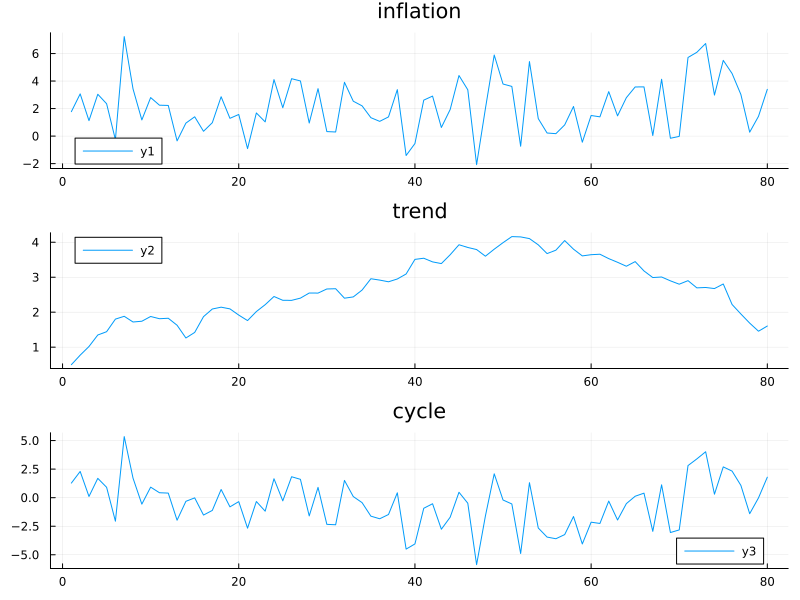

In [4]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

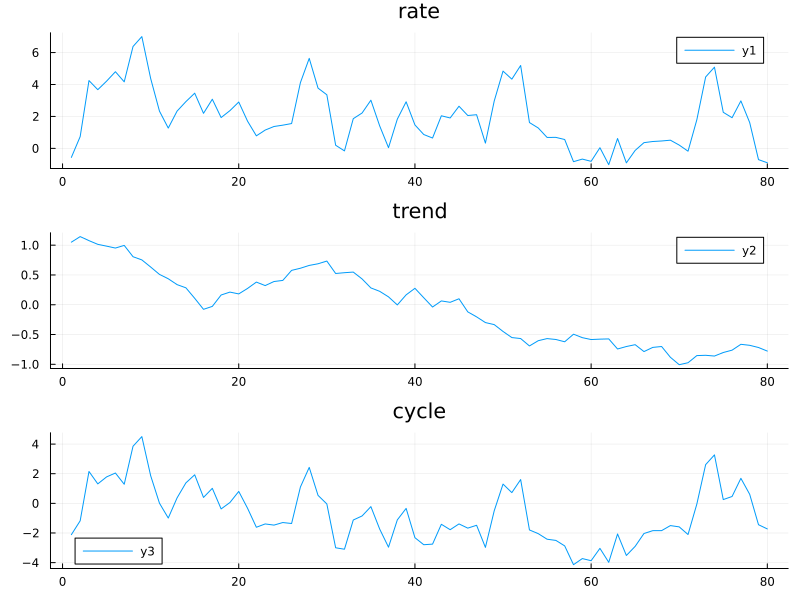

In [5]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [6]:
presample_mean = [mean(presample_data[:,1], dims=1)[1], mean(presample_data[:,2] - presample_data[:,1], dims=1)[1]]
display(presample_mean)

presample_variance = var(presample_data, dims=1)[1,:]
display(presample_variance)
display(presample_variance.^.5)


2-element Vector{Float64}:
 0.2744343640993232
 0.8884105314101403

2-element Vector{Float64}:
 4.7070539397696685
 2.5768233071527695

2-element Vector{Float64}:
 2.1695745988026474
 1.6052486745525658

In [7]:
n = 2 #number of observatin variables

priors = (
        initial_trend_mean = presample_mean,
        initial_cycle_mean = zeros(2),
        initial_trend_covariance = diagm([1., 1.]),
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([2. /10, 1. /20].^2),
        cycle_coeff_mean = zeros(2, 2),
        cycle_coeff_shrinkage_param = .2,
        cycle_covariance_mean = diagm(presample_variance), #diagm(presample_variance), 
        cycle_covariance_df = n+2
        )


(initial_trend_mean = [0.2744343640993232, 0.8884105314101403], initial_cycle_mean = [0.0, 0.0], initial_trend_covariance = [1.0 0.0; 0.0 1.0], trend_covariance_df = 100, trend_covariance_mean = [0.04000000000000001 0.0; 0.0 0.0025000000000000005], cycle_coeff_mean = [0.0 0.0; 0.0 0.0], cycle_coeff_shrinkage_param = 0.2, cycle_covariance_mean = [4.7070539397696685 0.0; 0.0 2.5768233071527695], cycle_covariance_df = 4)

In [8]:
trend_states_samples, cycle_states_samples, trend_covariance_samples, betas_samples, sigmas_samples = gibs_sampler(data, trend_mapping, priors; burnin = 5_000, n_samples = 5_000, thin=5)

trend_states_mean, trend_states_lower, trend_states_upper = compute_posterior_statistics(trend_states_samples, credible_level=0.95)  
cycle_states_mean, cycle_states_lower, cycle_states_upper = compute_posterior_statistics(cycle_states_samples, credible_level=0.95) 

([0.24252795607550545 -2.2125781791301176; 1.450165802214465 -0.994359049529683; … ; -0.9107903430587687 -2.6172123737638073; 1.0633288235920164 -2.798293303876002], [-0.9839759282739245 -3.5247661950540636; 0.2447069841965335 -2.3340070522855836; … ; -2.4707863311584015 -4.32876318433186; -0.5466106113843239 -4.593333058424772], [1.582538561448361 -0.6691650713656592; 2.8769657275273635 0.5378553893187182; … ; 0.6103813161792335 -1.0689654795211634; 2.536380918306143 -1.237200797114442])

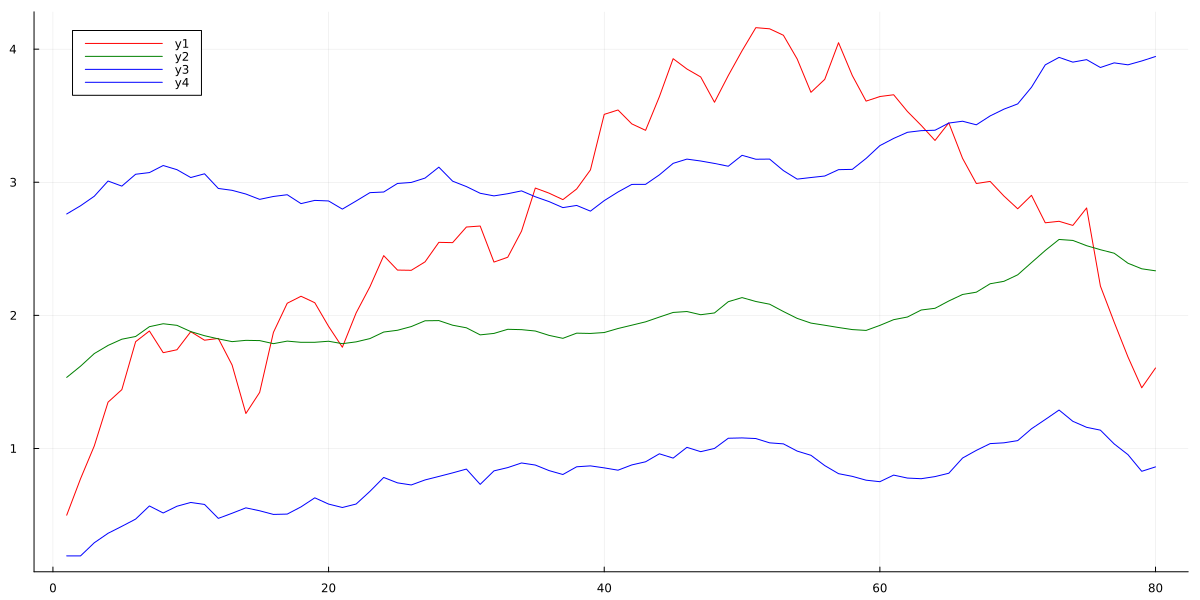

In [9]:
st = 1
plot(true_states[:,st]; color="red", size= (1200, 600))
plot!(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

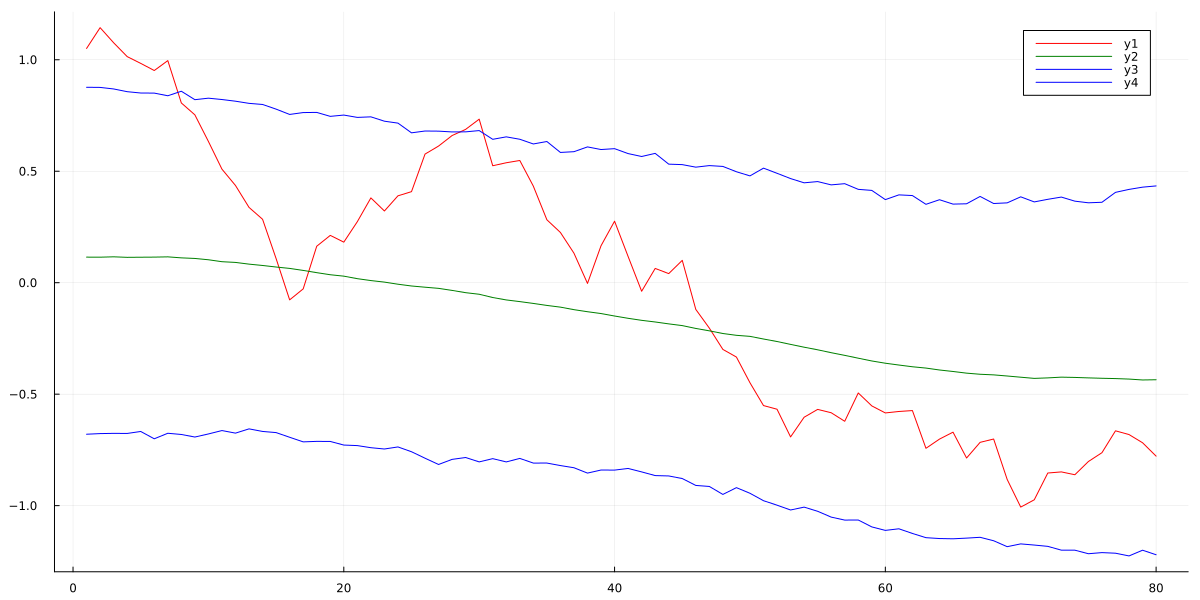

In [10]:
st = 2
plot(true_states[:,st]; color="red", size= (1200, 600))
plot!(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

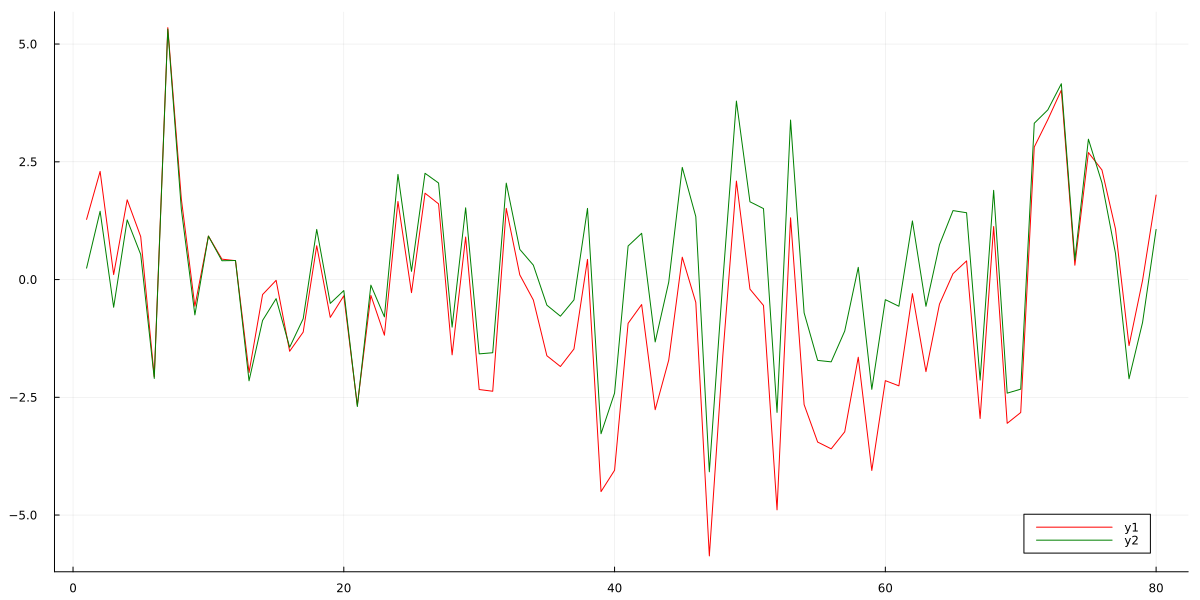

In [11]:
st=1
plot(true_states[:,3]; color="red", size= (1200, 600))
plot!(cycle_states_mean[:,st], color="green" )


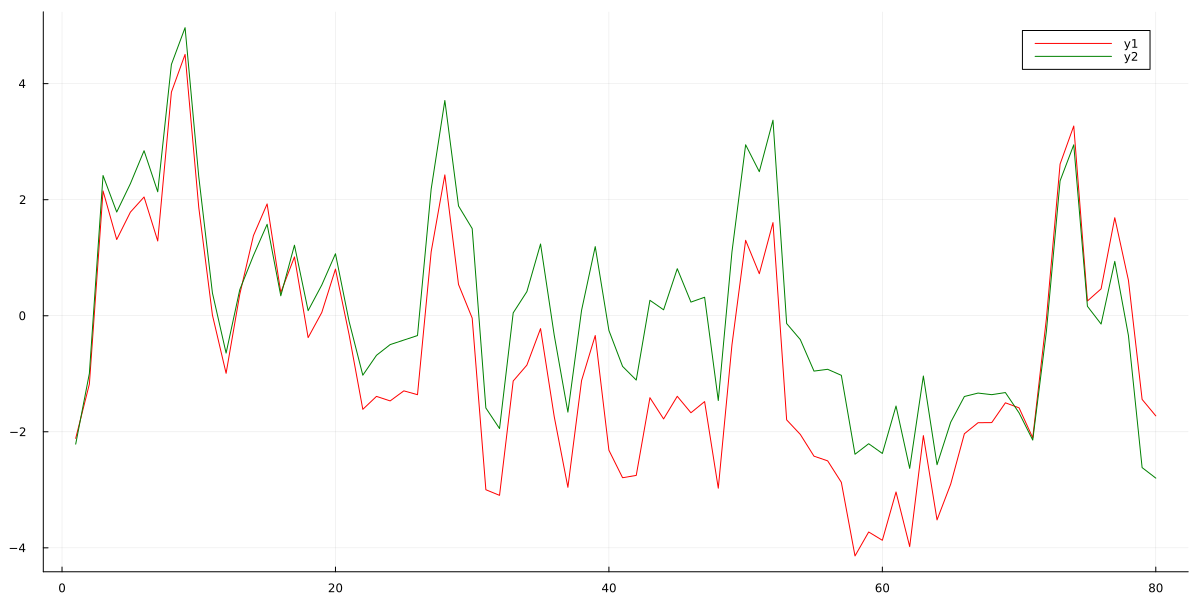

In [12]:
st = 2
plot(true_states[:,4]; color="red", size= (1200, 600))
plot!(cycle_states_mean[:,st], color="green" )

#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

In [13]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e * 1/(size(Y,1)-1)
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 0.037876203085272966
 0.009661080053014741

2-element Vector{Float64}:
 0.19461809547231976
 0.0982907933278328

In [14]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse   ess_bulk    ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64    Float64     Float64   Float64    ⋯

       Στ[1]    0.0421    0.0060    0.0002   944.0982   1064.4098    1.0003    ⋯
       Στ[2]   -0.0000    0.0010    0.0000   946.9242    919.3018    1.0007    ⋯
       Στ[3]   -0.0000    0.0010    0.0000   946.9242    919.3018    1.0007    ⋯
       Στ[4]    0.0027    0.0004    0.0000   929.9813    944.6841    0.9995    ⋯
                                                                1 column omitted


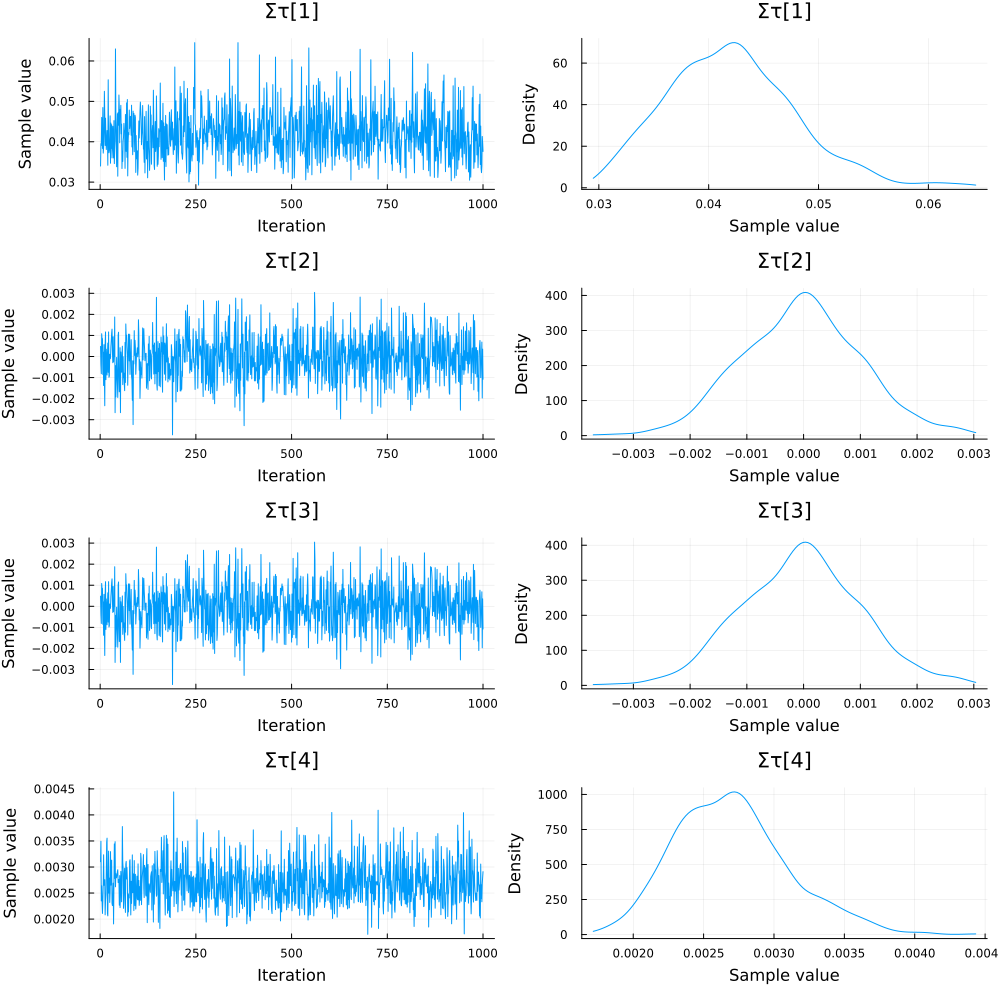

In [15]:
plot(trend_covariance_samples)

In [16]:
display(true_var_coeff)
summarystats(betas_samples)

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

          β1    0.0925    0.1142    0.0038    927.4351   908.0965    0.9993    ⋯
          β2    0.0594    0.1306    0.0041    985.5254   907.7013    0.9992    ⋯
          β3    0.2990    0.0770    0.0024   1037.8940   883.7294    1.0012    ⋯
          β4    0.5409    0.0980    0.0032    969.0053   942.4674    0.9998    ⋯
                                                                1 column omitted


In [17]:
display(true_cycle_covariance)
summarystats(sigmas_samples)

2×2 Matrix{Float64}:
  4.0      -0.00021
 -0.00021   1.0

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

       Σc[1]    4.1767    0.6645    0.0207   1029.5534   993.5808    1.0011    ⋯
       Σc[2]    0.0443    0.3653    0.0124    861.3215   945.3040    1.0042    ⋯
       Σc[3]    0.0443    0.3653    0.0124    861.3215   945.3040    1.0042    ⋯
       Σc[4]    2.1021    0.3535    0.0115    951.1844   978.4279    0.9994    ⋯
                                                                1 column omitted


uncoditional variance

In [72]:
unc_var  = (I(2) - true_var_coeff) * true_cycle_covariance
diag(unc_var) .^ .5

2-element Vector{Float64}:
 1.6733263280065844
 0.6325219363784943

In [73]:
Z = [1 0 0 0 1 0 0 0
       0 1 0 0 0 1 0 0
       0 1 1 0 0 0 1 0
       0 1 1 1 0 0 0 1]




4×8 Matrix{Int64}:
 1  0  0  0  1  0  0  0
 0  1  0  0  0  1  0  0
 0  1  1  0  0  0  1  0
 0  1  1  1  0  0  0  1

In [74]:
observation_tend_mapping  = [1 0 0 0 
                             0 1 0 0 
                             0 1 1 0 
                             0 1 1 1 ]

cycle_observation = I(4)

hcat(observation_tend_mapping, cycle_observation)

4×8 Matrix{Int64}:
 1  0  0  0  1  0  0  0
 0  1  0  0  0  1  0  0
 0  1  1  0  0  0  1  0
 0  1  1  1  0  0  0  1

In [75]:
gibs_sampler(data, trend_mapping, priors; burnin = 5_000, n_samples = 5_000, thin=5)

UndefVarError: UndefVarError: `trend_mapping` not defined in `Main`
Suggestion: check for spelling errors or missing imports.